## Assignment 3 - Due 10pm May 10th 2022 (by extension)
By Sam Archie (53743534/sar173)

In [1]:
# Import the fwi_calc and envlib code
import fwi_nz as fwi_calc
import envlib_helper as envlib

# Import other necessary libraries
import salem
import calendar
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from datetime import datetime, timedelta
from dask.diagnostics import ProgressBar
from tethysts import Tethys

### Task 1: FWI of FENZ and WRF Data
Understand how the modelled Fire Weather Index (FWI) compares to observations from AWSs leading to a real event of the Port Hills Fire that started on the afternoon of 13th of February 2017. 

##### Task 1a: Investigating the closest FENZ weather station
Use the nearest FENZ weather station to Early Valley Road (EVR), Christchurch. From the selected FENZ AWS construct the time series of FWI based on three different starting date scenarios (1 week prior to the fire event, 1 month prior, and 2 month prior). Avoid starting on a day when precipitation was occurring so adjust accordingly.

As the closest FENZ weather station to Early Valley Road was not captuing data before and during the Port Hills event, the FENZ weather station chosen to analyse is the **Motukarara** stattion. Hence, the first thing to do is grab the data from the station.

In [2]:
lat, lon = -43.7143, 172.5922 # Motukarara
station_data = envlib.get_data_from_lat_lon(ts=Tethys(), owner="FENZ", method="sensor_recording", product_code="raw_data", lat=lat, lon=lon, squeeze_dims=False).sel(height=2)

The following code blocks establish functions realting to converting datetimes between different timezones, namely NZST and UTC. They take care of daylight savings, and they were made into functions to be able to be re-used if needed. Further details are provided in the docstrings.

In [3]:
def determine_daylight_savings_dates(year):
    """
    Return the start and ending dates (incuding time) as datetime objects of the Daylight Savings scheme that started at the given year.
    Daylight Savings in NZST starts on the last Sunday of September at 2am and ends on the first Sunday of April at 2am.
    """

    # Set to last day number of the month
    last_day_of_september = datetime(year, 8, day=calendar.monthrange(year, 8)[1], hour=2, minute=0, second=0)
    # And offset by calculating the difference between the current weekday and what is needed to achieve Sunday (day 6)
    start_date = last_day_of_september + timedelta(days=6-last_day_of_september.weekday())

    # Set to the 7th day which is the end of the first week (this is not the end of the above start date though!)
    first_week_in_april = datetime(year, 3, day=7, hour=2, minute=0, second=0)
    # And offset by calculating the difference between the current weekday and what is needed to achieve Sunday (day 6)
    end_date = first_week_in_april + timedelta(days=6-first_week_in_april.weekday())

    return start_date, end_date

In [4]:
def convert_nzst_to_utc_time(nzst_datetime):
    """
    Convert a datetime object from a the local timezone (NZST to NZST-Daylight) to the UTC time zone.
    """

    # Determine the start and end dates for Daylight Savings
    daylight_start, daylight_end = determine_daylight_savings_dates(nzst_datetime.year)
    
    # Alter the datetime object by either 12 or 13 hours depending if it is in out or within the Daylight Savings dates.
    if nzst_datetime > daylight_start + timedelta(hours=1) and nzst_datetime < daylight_end + timedelta(hours=1):
        # Not in daylight savings, hence, alter from GMT+12 to GMT+0
        utc_datetime = nzst_datetime - timedelta(hours=12)
    else:
        # In daylight savings, hence, alter from GMT+13 to GMT+0
        utc_datetime = nzst_datetime - timedelta(hours=13)

    return utc_datetime

The following function is used to see if there was rainfall on a certain day. The significant threshold keyword exists as some days that recieve zero rainfall are not given a zero value, but a small value such as 0.00007247925 in the WRF datasets. This function is used in a while loop later on to step back a further day if it rained.

In [5]:
def rained_on_this_day(date, rain_dataset, significant_threshold=7.247925e-05):
    """
    Returns True if there was any rainfall (over the signifcant_threshold) during the entire selected date.
    """
    # Select the hourly rain measurements for the day in question
    rain_measurements_on_day = rain_dataset.sel(time=slice(date, date+timedelta(hours=23))).values
    # Check if any are above the significant threshold
    return (rain_measurements_on_day > significant_threshold).any()

Now, out of pure versatilty, the below function can take any xarray dataset and will call upon the plot method to generate a figure of 2D data

In [6]:
def plot_dataset(dataset, bounds=None, title=None, dpi=200, points=[], **kwargs):
    # Create an axis to plot on that resembles New Zealand
    ax = plt.axes(projection=ccrs.Orthographic(170, -45))
    # Plot the dataset on the axis. Transformation is done by salem, and any other user parameters for matplotlib are also inputted
    dataset.plot(ax=ax, transform=dataset.salem.cartopy(), zorder=1,  **kwargs)
    ax.coastlines() # Add the coastlines to the plot
    # Add point markers to certain lat/lon values
    for (x, y) in points:
        ax.plot([x], [y], "b", zorder=0, transform=ccrs.Geodetic())
    if title != None:
        ax.set_title(title) # Add a nicer title to the plot
    if bounds != None:
        ax.set_global()
        ax.set_extent(bounds) # Constrian the plot to some geographical extent
    # Get the current figure and set the dpi
    plt.gcf().set_dpi(dpi)

Before we begin, we need to define the date to analyse up to, and then convert that to UTC time!

In [7]:
end_date_local = datetime.strptime("2017-02-14", "%Y-%m-%d") # The 13th of February 2017
end_date_utc = convert_nzst_to_utc_time(end_date_local) # Use the above functions to convert from NZST-Daylight to UTC

Below is where the main analysis takes place. To put it simply, for every starting date scenario (1 week prior to the fire event, 1 month prior, and 2 month prior):
- the start date is calculated and adjusted if it rained on that day
- the fire weather index calculations are completed and plotted as a time series
- the metrics and index on the end_date are then saved for later comparision

start date 2017-02-05
end data 2017-02-13
RAIN matrix size: (1, 9)
RH matrix size:  (1, 9)
T matrix size:  (1, 9)
wind matrix size:  (1, 9)
start date 2017-01-16
end data 2017-02-13
RAIN matrix size: (1, 29)
RH matrix size:  (1, 29)
T matrix size:  (1, 29)
wind matrix size:  (1, 29)
start date 2016-12-19
end data 2017-02-13
RAIN matrix size: (1, 57)
RH matrix size:  (1, 57)
T matrix size:  (1, 57)
wind matrix size:  (1, 57)


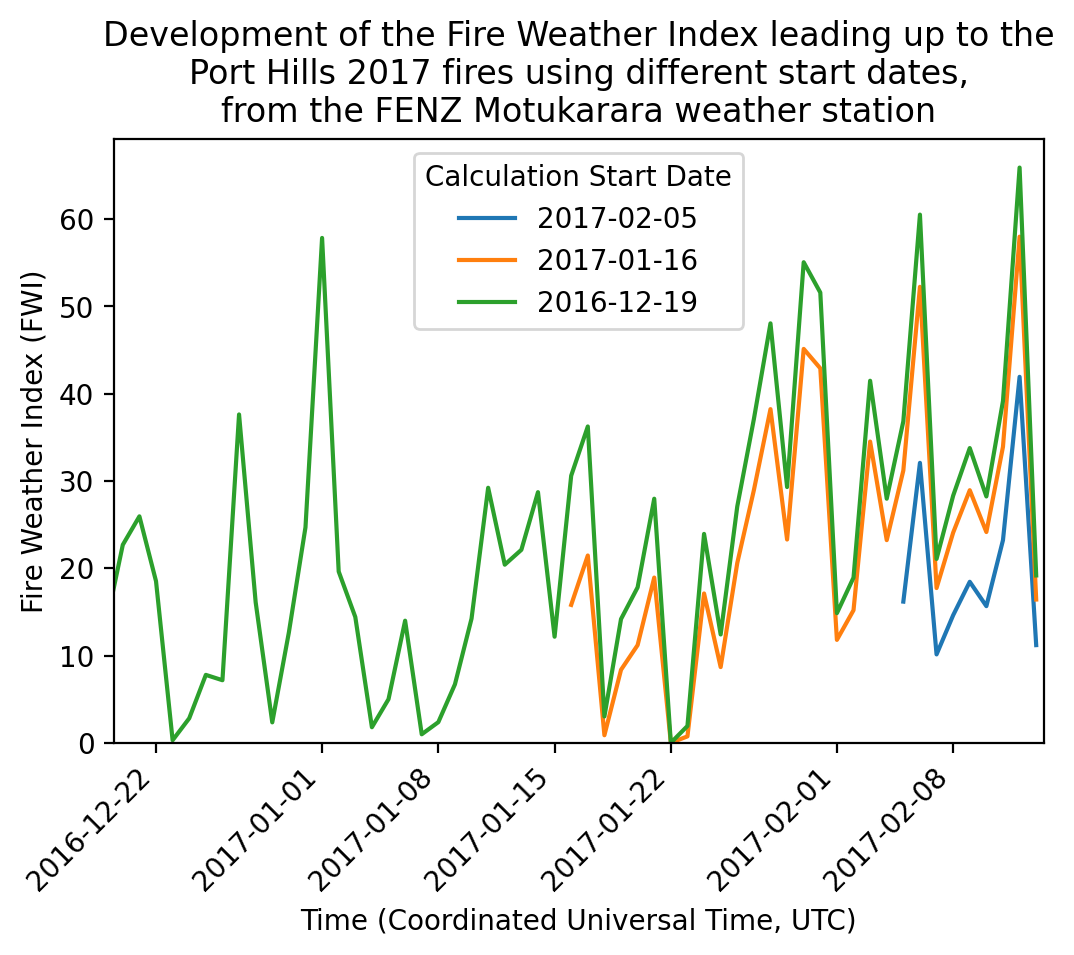

In [8]:
fwi_combined_results = pd.DataFrame() # Dataframe to add FWI metrics to compare
fig, ax = plt.subplots() # Setup the 1 ax figure to plot on

for time_delta in [timedelta(weeks=1), timedelta(weeks=4), timedelta(weeks=8)]:
    # Determine the start date of the FWI analysis by going back in time untill it hasn't rained
    start_date_utc = end_date_utc - time_delta 
    while rained_on_this_day(start_date_utc, station_data.precipitation, significant_threshold=0):
        # As it has rained on this start date, step back another day
        start_date_utc = start_date_utc - timedelta(days=1)

    # Convert the datetimes to strings as that is what is needed to work
    start_date_str_utc = start_date_utc.strftime("%Y-%m-%d")
    end_date_str_utc = end_date_utc.strftime("%Y-%m-%d")
    
    # Calculate the fire weather index 
    ffmc_data_fenz, dmc_data_fenz, dc_data_fenz, isi_data_fenz, bui_data_fenz, fwi_data_fenz = fwi_calc.FWI_combined_calc(
        station_data.temperature,
        station_data.relative_humidity,
        station_data.wind_speed,
        station_data.precipitation,
        start_date=start_date_str_utc,
        end_date=end_date_str_utc,
        ws_unit="m/s", 
        save_fwi=False, 
        chunks={"time":24},
        complevel=1
        )

    # Collate the values on the end date and add them to the DataFrame table
    fwi_combined_results = pd.concat([fwi_combined_results, 
        pd.DataFrame(
            data={
                "Start Date (UTC)": start_date_str_utc,
                "Station Data": "FENZ (Motukarara)",
                "Fine Fuel Moisture Content (FFMC)": ffmc_data_fenz.sel(time=end_date_str_utc).compute().values[0],
                "Duff Moisture Content (DMC)": dmc_data_fenz.sel(time=end_date_str_utc).compute().values[0],
                "Drought Code (DC)": dc_data_fenz.sel(time=end_date_str_utc).compute().values[0],
                "Initial Spread Index (ISI)": isi_data_fenz.sel(time=end_date_str_utc).compute().values[0], 
                "Buildup Index (BUI)": bui_data_fenz.sel(time=end_date_str_utc).compute().values[0],
                "Fire Weather Index (FWI)": fwi_data_fenz.sel(time=end_date_str_utc).compute().values[0]
            }, index=[0])
        ])

    # Plot the FWI values leading up to the event
    _ = ax.plot(fwi_data_fenz.time.values, fwi_data_fenz.values.reshape(len(fwi_data_fenz.time)), label=start_date_str_utc)

# Format the plot to be informative and be pretty
ax.legend(title="Calculation Start Date")
ax.set_xlim([start_date_utc, end_date_utc])
ax.set_ybound(lower=0)
ax.set_ylabel("Fire Weather Index (FWI)")
ax.set_xlabel("Time (Coordinated Universal Time, UTC)")
ax.set_title("Development of the Fire Weather Index leading up to the\nPort Hills 2017 fires using different start dates,\nfrom the FENZ Motukarara weather station")
plt.xticks(rotation=45, ha="right")
fig.set_dpi(200)

##### Task 1b: Investigating the closest WRF weather station
Complete the same as Task 1a, but using WRF weather station data

As the WRF data is gridded, we are able to select a location at Early Valley Road close to where the fire event happened. The following code block opens the relevant WRF data at Early Valley Road to complete the FWI calculation. 

In [9]:
lat, lon = -43.61709, 172.609 # Early Valley
start_date_utc_string = start_date_utc.strftime("%Y-%m-%d")
end_date_utc_string = end_date_utc.strftime("%Y-%m-%d")

with ProgressBar():
    temperature_dataset = xr.open_mfdataset("/mnt/data/MetService_WRF/T_201*.nc", chunks={"height":1, "time":100}).sel(height=2, time=slice(start_date_utc_string, end_date_utc_string)).sel(lat=lat, lon=lon, method="nearest").compute() - 273.15

    relative_humidity_dataset = xr.open_mfdataset("/mnt/data/MetService_WRF/RH_201*.nc", chunks={"height":1, "time":100}).sel(height=2, time=slice(start_date_utc_string, end_date_utc_string)).sel(lat=lat, lon=lon, method="nearest").compute()

    rain_dataset = xr.open_mfdataset("/mnt/data/MetService_WRF/RAINNC_201*.nc", chunks={"height":1, "time":100}).sel(time=slice(start_date_utc_string, end_date_utc_string)).sel(lat=lat, lon=lon, method="nearest").compute()

    u_dataset = xr.open_mfdataset("/mnt/data/MetService_WRF/U_201*.nc", chunks={"height":1, "time":100}).sel(height=10, time=slice(start_date_utc_string, end_date_utc_string)).sel(lat=lat, lon=lon, method="nearest")

    v_dataset = xr.open_mfdataset("/mnt/data/MetService_WRF/V_201*.nc", chunks={"height":1, "time":100}).sel(height=10, time=slice(start_date_utc_string, end_date_utc_string)).sel(lat=lat, lon=lon, method="nearest")

    windspeed_dataset = xr.ufuncs.sqrt(u_dataset.U **2 + v_dataset.V ** 2).compute()

[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.8s


Below is where the main analysis takes place. To put it simply, for every starting date scenario (1 week prior to the fire event, 1 month prior, and 2 month prior):
- the start date is calculated and adjusted if it rained on that day
- the fire weather index calculations are completed and plotted as a time series
- the metrics and index on the end_date are then saved for later comparision

start date 2017-02-05
end data 2017-02-13
RAIN matrix size: (9,)
RH matrix size:  (9,)
T matrix size:  (9,)
wind matrix size:  (9,)
start date 2017-01-16
end data 2017-02-13
RAIN matrix size: (29,)
RH matrix size:  (29,)
T matrix size:  (29,)
wind matrix size:  (29,)
here 2016-12-19
start date <xarray.DataArray 'time' ()>
array('2016-12-20T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2016-12-19
    lat      float64 -43.61
    lon      float64 172.6
end data 2017-02-13
RAIN matrix size: (56,)
RH matrix size:  (56,)
T matrix size:  (56,)
wind matrix size:  (56,)


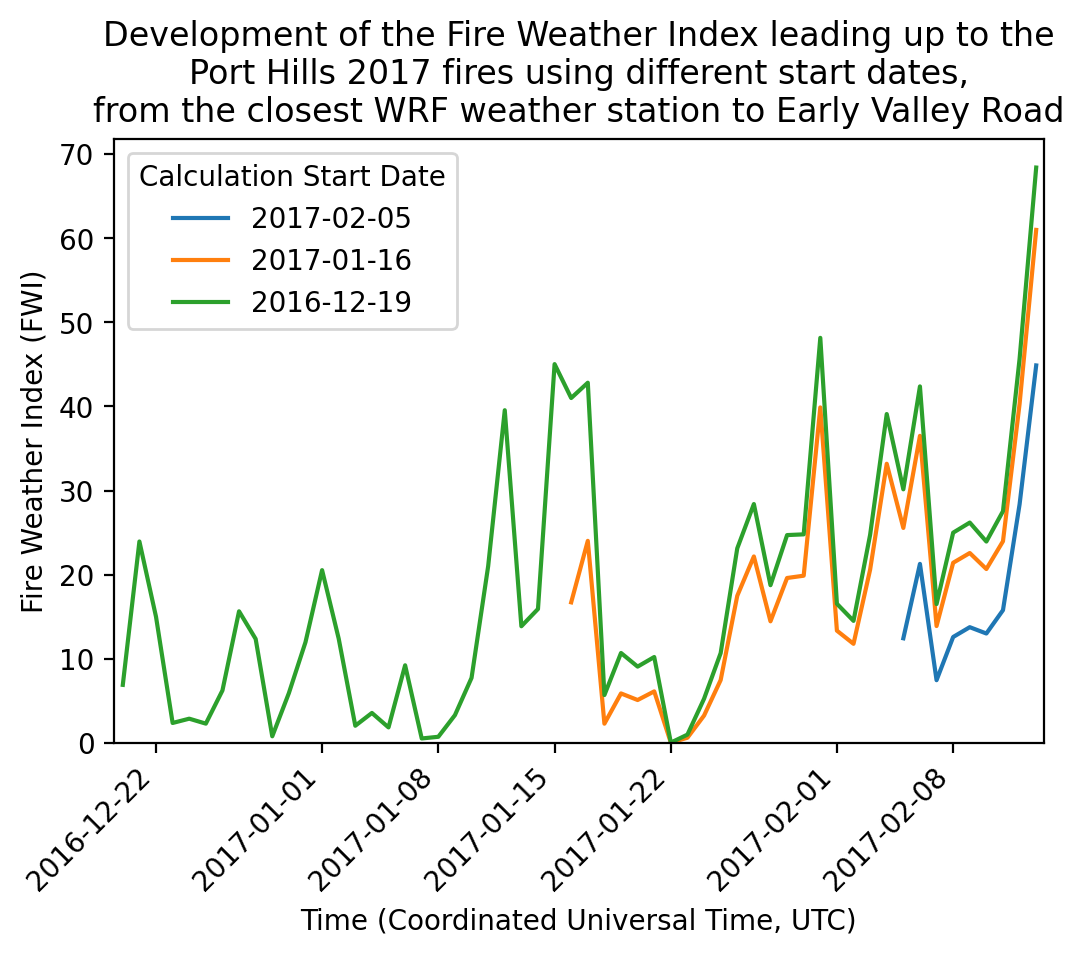

In [10]:
fig, ax = plt.subplots() # Setup the 1 ax figure to plot on

for time_delta in [timedelta(weeks=1), timedelta(weeks=4), timedelta(weeks=8)]:
    # Determine the start date of the FWI analysis by going back in time untill it hasn't rained
    start_date_utc = end_date_utc - time_delta 
    while rained_on_this_day(start_date_utc, station_data.precipitation, significant_threshold=0):
        # As it has rained on this start date, step back another day
        start_date_utc = start_date_utc - timedelta(days=1)

    # Convert the datetimes to strings as that is what is needed to work
    start_date_utc_string = start_date_utc.strftime("%Y-%m-%d")
    end_date_utc_string = end_date_utc.strftime("%Y-%m-%d")

    # Calculate the fire weather index 
    ffmc_data_wrf, dmc_data_wrf, dc_data_wrf, isi_data_wrf, bui_data_wrf, fwi_data_wrf = fwi_calc.FWI_combined_calc(
        temperature_dataset.T,
        relative_humidity_dataset.RH,
        windspeed_dataset,
        rain_dataset.RAINNC,
        start_date=start_date_utc_string,
        end_date=end_date_utc_string,
        ws_unit="m/s", 
        save_fwi=False, 
        chunks={"time":24},
        complevel=1
        )

    # Collate the values on the end date and add them to the DataFrame table
    fwi_combined_results = pd.concat([fwi_combined_results, 
        pd.DataFrame(
            data={
                "Start Date (UTC)": start_date_utc_string,
                "Station Data": "WRF (Early Valley Road)", 
                "Fine Fuel Moisture Content (FFMC)": ffmc_data_wrf.sel(time=end_date_utc_string).values.tolist(),
                "Duff Moisture Content (DMC)": dmc_data_wrf.sel(time=end_date_utc_string).values.tolist(),
                "Drought Code (DC)": dc_data_wrf.sel(time=end_date_utc_string).values.tolist(),
                "Initial Spread Index (ISI)": isi_data_wrf.sel(time=end_date_utc_string).values.tolist(), 
                "Buildup Index (BUI)": bui_data_wrf.sel(time=end_date_utc_string).values.tolist(),
                "Fire Weather Index (FWI)": fwi_data_wrf.sel(time=end_date_utc_string).values.tolist()
            }, index=[0])
        ])

    # Plot the FWI values leading up to the event
    _ = ax.plot(fwi_data_wrf.time.values, fwi_data_wrf.values.reshape(len(fwi_data_wrf.time)), label=start_date_utc_string)

# Format the plot to be informative and be pretty
ax.legend(title="Calculation Start Date")
ax.set_xlim([start_date_utc, end_date_utc])
ax.set_ybound(lower=0)
ax.set_ylabel("Fire Weather Index (FWI)")
ax.set_xlabel("Time (Coordinated Universal Time, UTC)")
ax.set_title("Development of the Fire Weather Index leading up to the\nPort Hills 2017 fires using different start dates,\nfrom the closest WRF weather station to Early Valley Road")
plt.xticks(rotation=45, ha="right")
fig.set_dpi(200)

##### Task 1c: Compare and contrast the two stations
Compare and discuss the FWI from task 1a and 1b. Give possible explanations to the differences and use data/figures to support

The main conclusion that can be drawn from the comparision of the two data types (WRF vs FENZ) is the Fire Weather Index (FWI) calculated from the FENZ Motukarara Station is lower than the WRF data from Early Valley Road, regardless of the start date chosen for the calculations. 

The value of all the indices are given in the table below, and time-series of all weather datasets and indices (based on a 2 month start date from the end date) are in a Figure further below. 

#### Accuracy vs Start date
Firstly, let's discuss the use of different start dates for the FWI calculation. Evidently, choosing a start date further away from the end date increases the accuracy of the indices that form the FWI. As the indices are based upon the previous day's indices, the initialiation conditions are critical to ensuring the calculations are started correctly. This is evident in the Table below where the DMC, DC, BUI and FWI indices increase in value when the calulation starts at an earlier date.

However, it can be seen that certain parameters (FFMC and ISI) do not change when the start date is altered. As the Initial Spread Index (ISI) is soley based upon the Fine Fuel Moisture Code (FFMC) which is derived from all 4 weather datasets, it is no wonder that these two variables are inter-related. Clearly, the 3 scenarios (1 week prior to the fire event, 1 month prior, and 2 month prior) converged to the exact same values for FFMC and ISI. 

Thus, it is important to chose a start date that is further away from the end date to ensure accurate representations of the MC, DC, BUI indices which lead to a correct FWI value.

#### Accuracy vs Data Source
The differences from FFMC and ISI between the two stations can be attributed to the slight change in atmospheric measurements (due to different geographical locations). Suprisingly, a decrease in relative humidity and windspeed and a lack of rainfall, on the 13th of February for the FENZ weather station results in a durastic decrease in the FWI index! This decrease was caused as the FWI index is sensitive to the FFMC index and other moisture codes (due to rainfall), which shows a sharp decrease in the day of the fire event, which altered the ISI index as well. 

More importantly, the WRF dataset is assumed to be interpolated between various weather stations in the area and is not entirely correct at the geographic location chosen. Whereas the FENZ data is based on capturing devices, as is authentic for the location. This leads me to believe that the FENZ data is a true representation of the current conditions. 

#### Summary
It is my belief that the FENZ data more accurately captures the true conditions of the Fire Weather Index at the Port Hills. However, I would also like to acknowledge the accuracy of the FWI calculation method and its limitations used. For example, this method is centered around flat terrain which is not the case for the FENZ station being on a hill. These indices should be used to represnt the conditions, but should be taken as absolutely correct.



In [11]:
fwi_combined_results.round(2).set_index(["Station Data", "Start Date (UTC)"])

Fine Fuel Moisture Content (FFMC)  \
Station Data            Start Date (UTC)                                      
FENZ (Motukarara)       2017-02-05                                    87.72   
                        2017-01-16                                    87.72   
                        2016-12-19                                    87.72   
WRF (Early Valley Road) 2017-02-05                                    91.22   
                        2017-01-16                                    91.22   
                        2016-12-19                                    91.22   

                                          Duff Moisture Content (DMC)  \
Station Data            Start Date (UTC)                                
FENZ (Motukarara)       2017-02-05                              28.53   
                        2017-01-16                              58.68   
                        2016-12-19                              60.67   
WRF (Early Valley Road) 2017-02-05                              31.65   
                        2017-01-16                              63.55   
                        2016-12-19                              65.82   

                                          Drought Code (DC)  \
Station Data            Start Date (UTC)                      
FENZ (Motukarara)       2017-02-05                    74.13   
                        2017-01-16                   144.97   
                        2016-12-19                   274.31   
WRF (Early Valley Road) 2017-02-05                    77.38   
                        2017-01-16                   159.68   
                        2016-12-19                   276.27   

                                          Initial Spread Index (ISI)  \
Station Data            Start Date (UTC)                               
FENZ (Motukarara)       2017-02-05                              5.88   
                        2017-01-16                              5.88   
                        2016-12-19                              5.88   
WRF (Early Valley Road) 2017-02-05                             39.15   
                        2017-01-16                             39.15   
                        2016-12-19                             39.15   

                                          Buildup Index (BUI)  \
Station Data            Start Date (UTC)                        
FENZ (Motukarara)       2017-02-05                      29.08   
                        2017-01-16                      58.67   
                        2016-12-19                      78.14   
WRF (Early Valley Road) 2017-02-05                      31.64   
                        2017-01-16                      63.71   
                        2016-12-19                      82.50   

                                          Fire Weather Index (FWI)  
Station Data            Start Date (UTC)                            
FENZ (Motukarara)       2017-02-05                           11.19  
                        2017-01-16                           16.41  
                        2016-12-19                           19.17  
WRF (Early Valley Road) 2017-02-05                           44.88  
                        2017-01-16                           61.00  
                        2016-12-19                           68.41

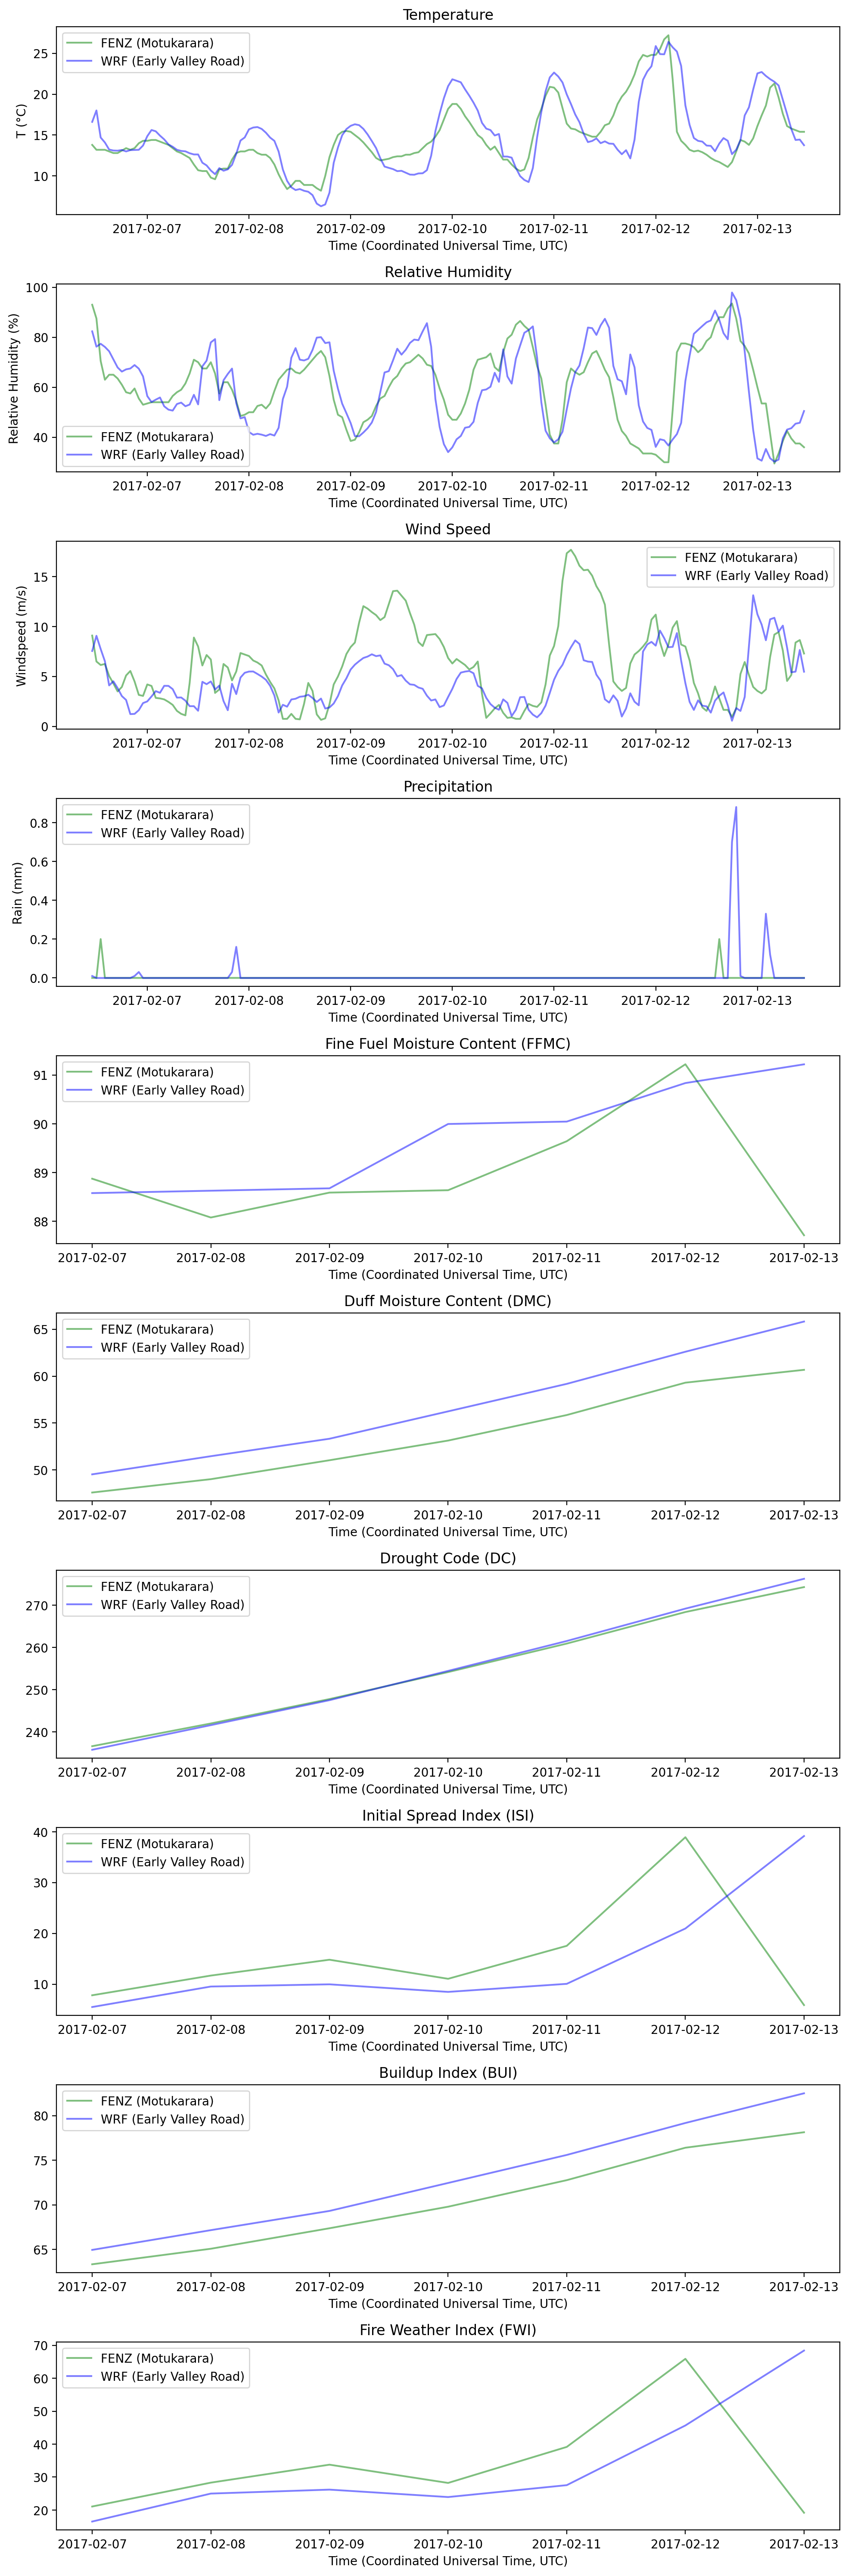

In [23]:
# Collate all the datasets to plot (order is title, axis_label, fenz_data, wrf_data)
datasets = [
    ("Temperature", r"T ($\degree$C)", station_data.temperature, temperature_dataset.T),
    ("Relative Humidity", "Relative Humidity (%)", station_data.relative_humidity, relative_humidity_dataset.RH), 
    ("Wind Speed", "Windspeed (m/s)", station_data.wind_speed, windspeed_dataset), 
    ("Precipitation", "Rain (mm)", station_data.precipitation, rain_dataset.RAINNC), 
    ("Fine Fuel Moisture Content (FFMC)", "", ffmc_data_fenz, ffmc_data_wrf),
    ("Duff Moisture Content (DMC)", "", dmc_data_fenz, dmc_data_wrf), 
    ("Drought Code (DC)", "", dc_data_fenz, dc_data_wrf), 
    ("Initial Spread Index (ISI)", "", isi_data_fenz, isi_data_wrf), 
    ("Buildup Index (BUI)", "", bui_data_fenz, bui_data_wrf), 
    ("Fire Weather Index (FWI)", "", fwi_data_fenz, fwi_data_wrf)
    ]

# Set up the multiplot to plot each dataset onto
fig, axs = plt.subplots(len(datasets), 1, figsize=(10, 30))

# Choose how much time to analyse, default is set to 7 days from the fire event
start_date_plot = end_date_utc - timedelta(days=7)

# Loop through each dataset to visualise
for (dataset_name, y_axis_label, fenz_dataset, wrf_dataset), ax in zip(datasets, axs.flat):
    # Extract and plot the FENZ data 
    fenz_data = fenz_dataset.sel(time=slice(start_date_plot, end_date_utc))
    ax.plot(fenz_data.time.values, fenz_data.values.reshape(fenz_data.time.values.shape), "g", alpha=0.5, label="FENZ (Motukarara)")
    
    # Extract and plot the WRF data 
    wrf_data = wrf_dataset.sel(time=slice(start_date_plot, end_date_utc))
    ax.plot(wrf_data.time.values, wrf_data.values.reshape(wrf_data.time.values.shape), "b", alpha=0.5, label="WRF (Early Valley Road)")

    # Configure the ax to look professional
    ax.set_title(dataset_name)
    ax.set_xlabel("Time (Coordinated Universal Time, UTC)")
    ax.set_ylabel(y_axis_label)
    ax.legend()

plt.tight_layout()
fig.set_dpi(200)

### Task 2: Develop a national fire weather climatology
To develop a national fire weather climatology that can find the highest occurances of extreme fire weather conditions and also to determine if there is a shift in fire weather times in the season.

##### Task 2a: Investigating the likelihood of extreme fire risk nationally
Where are the regions in New Zealand that exhibit the highest occurrence of extreme fire weather conditions? Explain the potential reasons for the spatial heterogeneity. 

Firstly, we need to open the relevant WRF data nationwide to complete the FWI calculation. A mask of the New Zealand coastline is applied to the datasets through the soil moisture dataset.

In [25]:
start_date_str = "2016-01-01"
end_date_str = "2020-12-31" 

nz_land_mask = xr.open_dataset("/mnt/data/MetService_WRF/SMOIS_20000101000000.nc").SMOIS.isel(height=0, time=0) < 0.9

temperature_dataset = (xr.open_mfdataset("/mnt/data/MetService_WRF/T_20*.nc", chunks={"height":1, "time":24}).sel(height=2, time=slice(start_date_str, end_date_str)) - 273.15).where(nz_land_mask)

relative_humidity_dataset = xr.open_mfdataset("/mnt/data/MetService_WRF/RH_20*.nc", chunks={"height":1, "time":24}).sel(height=2, time=slice(start_date_str, end_date_str)).where(nz_land_mask)

rain_dataset = xr.open_mfdataset("/mnt/data/MetService_WRF/RAINNC_20*.nc", chunks={"time":24}).sel(time=slice(start_date_str, end_date_str)).where(nz_land_mask)

windspeed_dataset = xr.ufuncs.sqrt(xr.open_mfdataset("/mnt/data/MetService_WRF/U_20*.nc", chunks={"height":1, "time":24}).where(nz_land_mask).U **2 + xr.open_mfdataset("/mnt/data/MetService_WRF/V_20*.nc", chunks={"height":1, "time":24}).where(nz_land_mask).V ** 2).sel(height=10, time=slice(start_date_str, end_date_str))

The FWI calculations are then completed for the 5 years and saved to disk as netCDF files

In [3]:
with ProgressBar():
    _, _, _, _, _, _ = fwi_calc.FWI_combined_calc(
        temperature_dataset.T,
        relative_humidity_dataset.RH,
        windspeed_dataset,
        rain_dataset.RAINNC, 
        start_date=start_date_str,
        end_date=end_date_str,
        ws_unit="m/s", 
        save_fwi=True,
        complevel=1, 
        save_loc="FWI_indicies/"
        )

here 2016-01-01
start date <xarray.DataArray 'time' ()>
array('2016-01-02T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2016-01-01
    height   float64 1.0
end data <xarray.DataArray 'time' ()>
array('2020-12-31T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-12-31
    height   float64 1.0
RAIN matrix size: (1826, 508, 472)
RH matrix size:  (1826, 508, 472)
T matrix size:  (1826, 508, 472)
wind matrix size:  (1826, 508, 472)
364
Current Time = 14:37:46 . Saving Fire Weather Indices (2016) ...
[########################################] | 100% Completed | 33min  3.0s
Current Time = 15:10:54 . File saved. Continue next year ...
[########################################] | 100% Completed | 15.2s
[########################################] | 100% Completed | 15.0s
[########################################] | 100% Completed | 14.9s
729
Current Time = 15:12:46 . Saving Fire Weather Indices (2017) ...
[##########

The FWI indices are then opened from the saved files, and the amount of days over the threshold of 31 are counted for each pixel in the dataset.

In [13]:
with ProgressBar():
    fwi_data = xr.open_mfdataset("/home/UOCNT/sar173/FWI_indicies/FWI_*.nc").FWI
    days_over_FWI_31 = fwi_data.where(fwi_data >= 31).count(dim="time").compute()

[########################################] | 100% Completed |  6.8s


And finally plot the spatial data to show the spatial distribution of days of FWi over 31 to identify 'hotspots'!

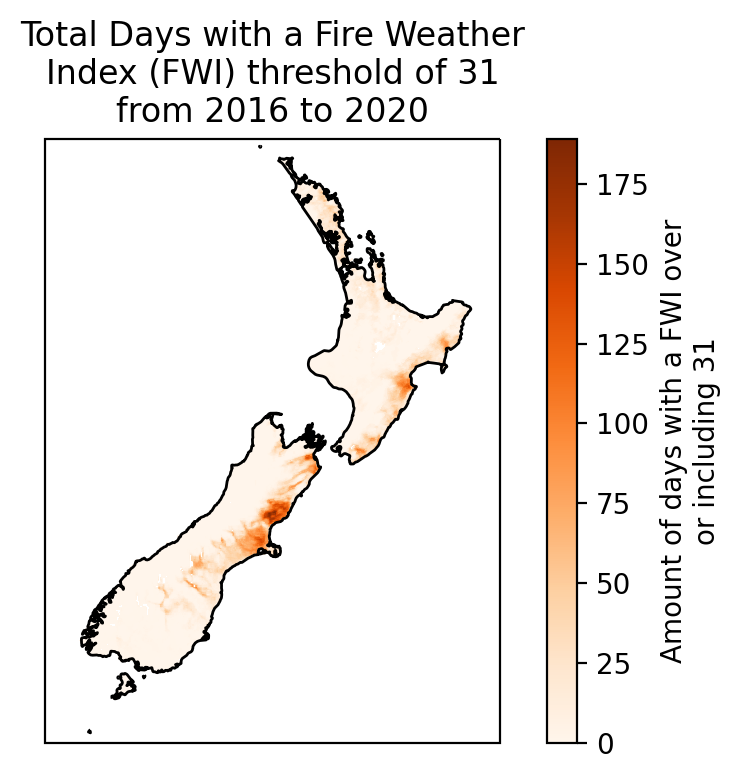

In [25]:
days_over_FWI_31.name = "Amount of days with a FWI over or including 31"
plot_dataset(days_over_FWI_31.where(nz_land_mask), title="Total Days with a Fire Weather\nIndex (FWI) threshold of 31\nfrom 2016 to 2020", cmap="Oranges")

The main conclusion that can be drawn is there are regions that exhibit the highest occurance of extreme fire weather event, as these regions are highlighted in dark red above as: Canterbury, Marlborough, Wellington, Hawkes Bay and Gisbourne. 

These spatial extremes are believed to exist potentially because of common climates, such as:
- high average temperatures
- low average relative humidities
- low average rainfall 
- high average windspeeds

These can be seen throughout the following 4 figures showing the mean climate values over the entire country from 2016 to 2020. 

More importantly, each climate influences the FWI calculation by:
- a higher temperature affects all of the indices which causes a change in the FWI
- a lower relative humidity affects the FFMC and DMC indices, which cause a change in the FWI 
- a lower rainfall also affects all of the indices, as it changes moisture contents and codes which casues a change in the FWI
- a higher windspeed directly controls the FFMC and ISI which increases the FWI

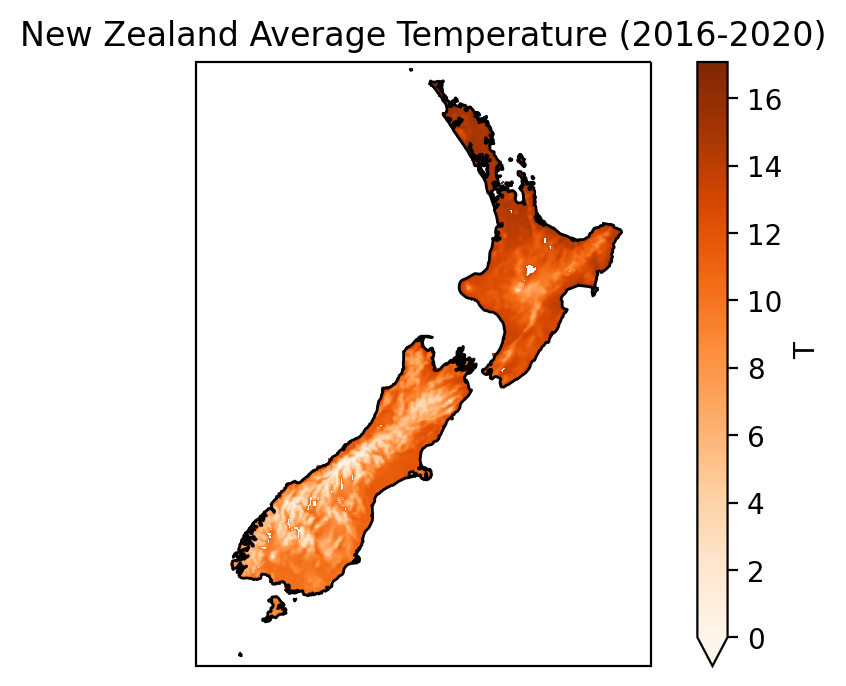

In [26]:
plot_dataset(temperature_dataset.T.mean(dim="time"), title="New Zealand Average Temperature (2016-2020)", vmin=0, cmap="Oranges")

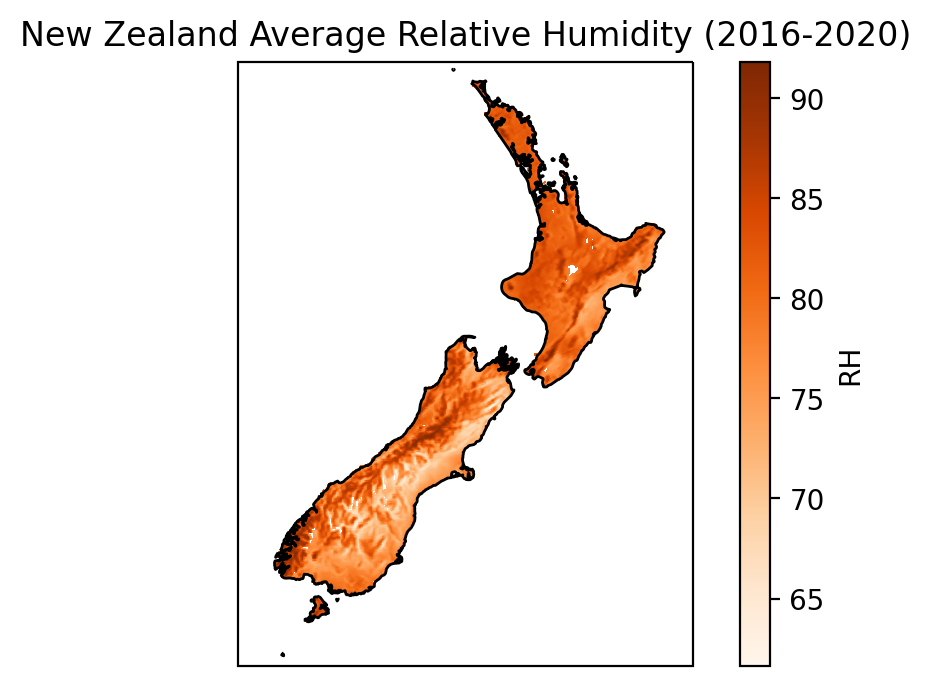

In [27]:
plot_dataset(relative_humidity_dataset.RH.mean(dim="time"), title="New Zealand Average Relative Humidity (2016-2020)", cmap="Oranges")

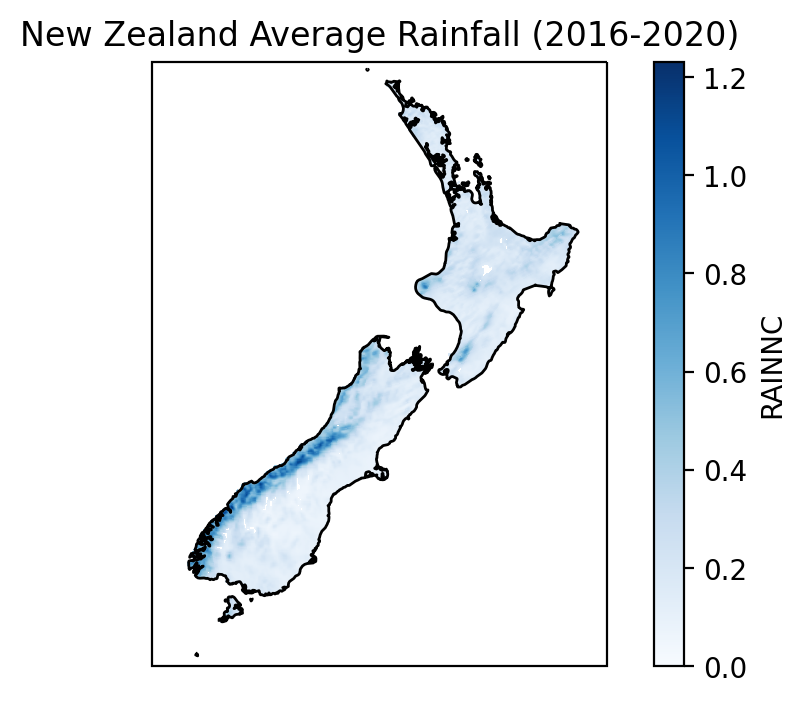

In [33]:
plot_dataset(rain_dataset.RAINNC.mean(dim="time"), title="New Zealand Average Rainfall (2016-2020)", vmin=0, cmap="Blues")

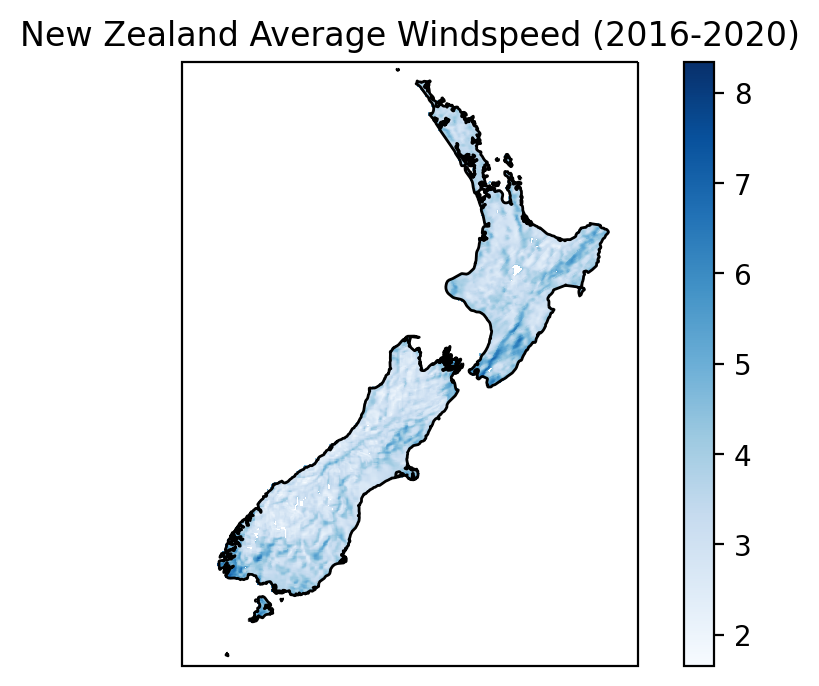

In [34]:
plot_dataset(windspeed_dataset.mean(dim="time"), title="New Zealand Average Windspeed (2016-2020)", cmap="Blues")

##### Task 2b: Explore if there is a shift in Fire Weather
Over the last 20 years, is New Zealand experiencing a  shift in fire weather to earlier 
times in the season?

Firstly, open the yearly datasets for the FWI to save computational time that were pre-run. The number of days in each selected month (September to March) are then counted and added to the 'collated_counts' DataFrame for comparison

In [19]:
collated_counts = pd.DataFrame()
# For the individual axis titles, set up a dictionary mapping month numbers to formal month names
month_num_to_name = {9: "September", 10: "October", 11: "November", 12: "December", 1: "January", 2: "February", 3: "March", }
years_to_analyse = range(2000, 2020+1)

for year in years_to_analyse:
    fwi_data = xr.open_dataset(f"/mnt/data/FWI_WRF/FWI_{year}.nc").FWI
    fwi_data = fwi_data.where(fwi_data >= 17).groupby("time.month").count()
    collated_counts = pd.concat([collated_counts, pd.DataFrame(data={f"{month_number}": int(fwi_data.sel(month=month_number).sum().values) for month_number in month_num_to_name.keys()}, index=[f"{year}-01-01"])])

# Convert the strings to dates
collated_counts["Date"] = collated_counts.index.astype("datetime64[ns]")
collated_counts.set_index("Date", inplace=True)

And finally, plot the collated_counts onto seperate axis - one for each month!

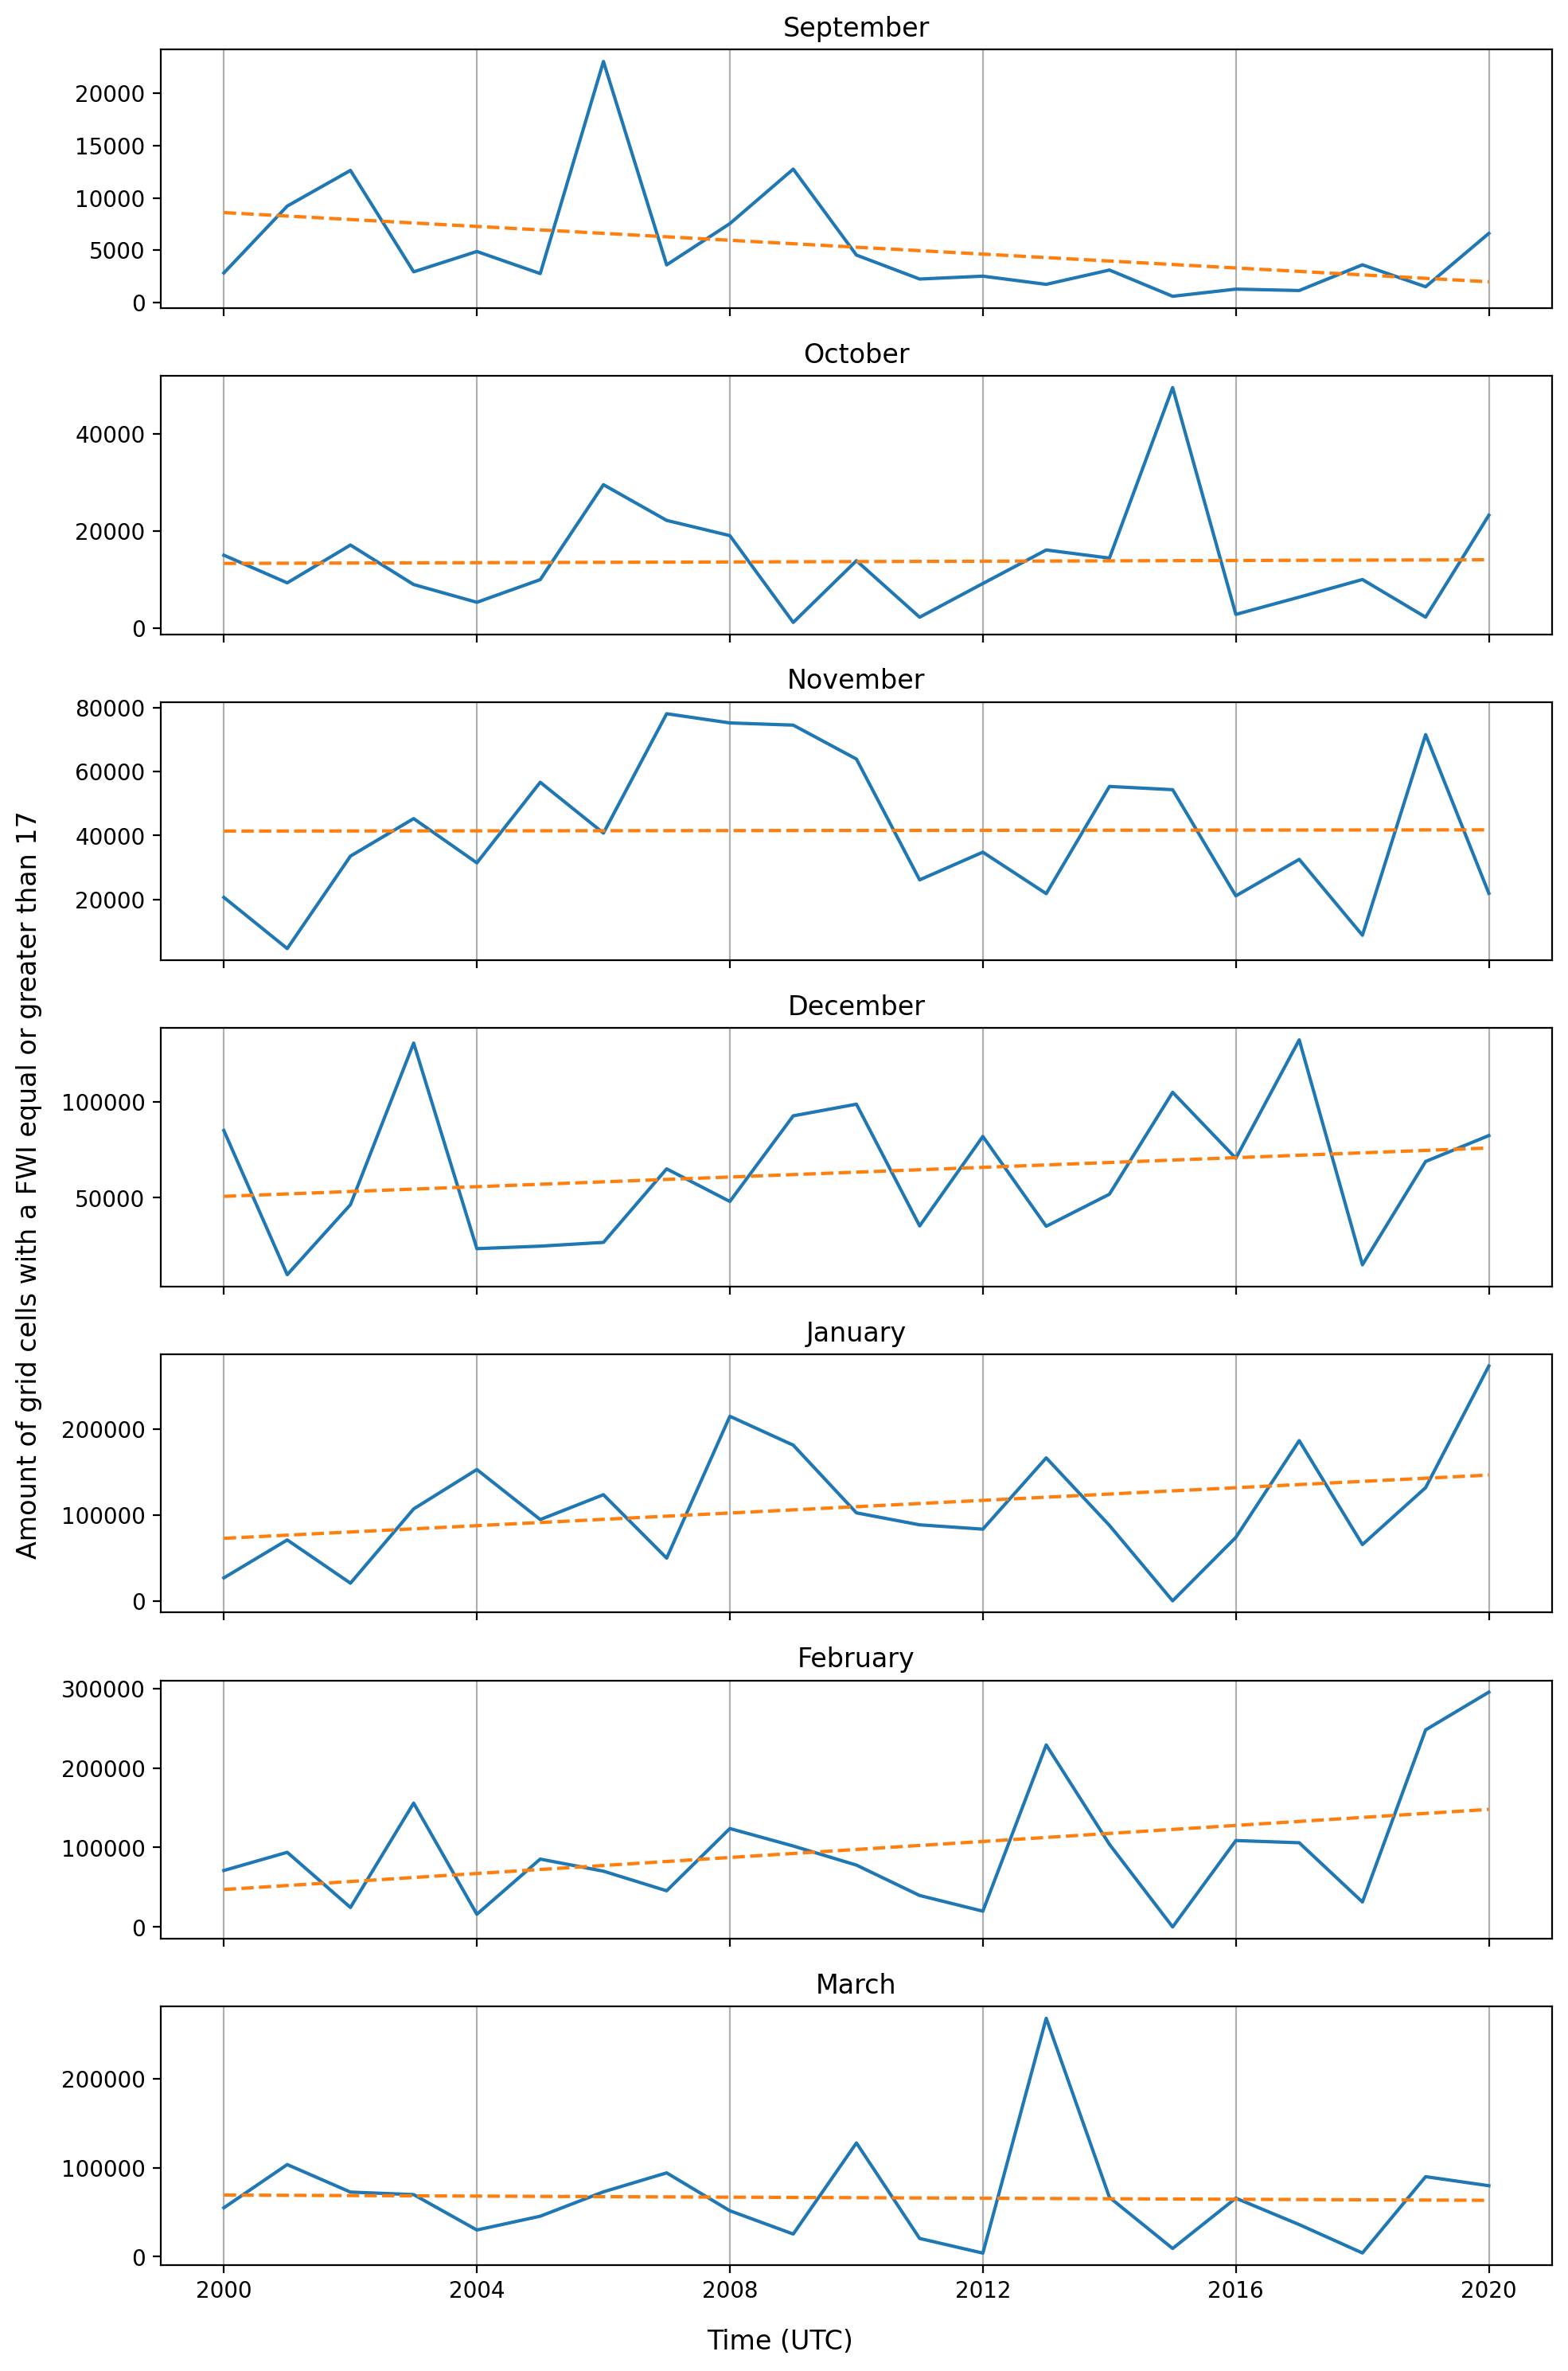

In [24]:
# Setup the 7 ax figure to plot each of the monthly data onto
fig, axs = plt.subplots(len(collated_counts.columns), 1, figsize=(10, 15), sharex=True)

# Plot each month onto a different axis
for month_number, ax in zip(list(collated_counts.columns), axs.flat):
    ax.plot(collated_counts.index, collated_counts.loc[:, month_number].tolist())
    ax.plot(collated_counts.index, np.poly1d(np.polyfit(years_to_analyse, collated_counts.loc[:, month_number].tolist(), deg=1))(years_to_analyse), "--")
    ax.set_title(month_num_to_name[int(month_number)])
    ax.grid(which="both", axis="x")

# Make the figure look pretty
fig.supylabel("Amount of grid cells with a FWI equal or greater than 17")
fig.supxlabel("Time (UTC)")
plt.tight_layout()
fig.set_dpi(200)

The main conclusion that can be drawn is that there is **not** a shift in fire-weather to earlier times in the season. Using linear curve fitting, there is a slight decrease in occurances of extreme fire-weather at the earlier parts of the season (September to November). However, there is a clear increase in extreme fire-weather occurances form December to February. 